In [50]:
# Importing basic libraries
# Provides functions to interact with the operating system, e.g., managing directories and files
import os
# Allows tracking time for performance measurement or adding delays
import time
# Used for creating visualizations, such as plotting images or graphs
import matplotlib.pyplot as plt
# Fundamental package for scientific computing, helpful for array operations
import numpy as np
# PIL (Pillow) for image processing, such as loading and manipulating images
from PIL import Image
# Main TensorFlow library for deep learning and machine learning tasks
import tensorflow as tf
# TensorFlow Hub for loading pre-trained models from the TensorFlow Model Hub
import tensorflow_hub as hub

# Setting an environment variable for TensorFlow Hub to show download progress
os.environ['TFHUB_DOWNLOAD_PROGRESS']='True'

In [51]:
# Importing the requests library to handle HTTP requests
import requests
# Define the URL for the image to be downloaded
url = 'https://raw.githubusercontent.com/Masterx-AI/Project_Image_Super_Resolution/main/tiger.jpg'
# Send a GET request to the specified URL to fetch the image content
r = requests.get(url, allow_redirects=True)
# Open a local file 'tiger.jpg' in write-binary mode ('wb') and save the content from the request
open('tiger.jpg', 'wb').write(r.content)
# Define the path to the saved image file
IMAGE_PATH = 'tiger.jpg'
# Define the URL to the pre-trained super-resolution model on TensorFlow Hub
SAVED_MODEL_PATH = "https://tfhub.dev/captain-pool/esrgan-tf2/1"

In [52]:
def preprocess_image(image_path):
   '''Loads the image given make it ready for
      the model
      Args:
        image_path: Path to the image file
   '''
   # Read the image file and decode it into an image tensor
   image = tf.image.decode_image(tf.io.read_file(image_path))
   # Check if the image has an alpha channel (4 channels), and remove it if present
   if image.shape[-1] == 4:
    # Keeps only the first 3 channels (RGB)
    image = image[...,:-1]
  # Calculate the largest size that is divisible by 4 for the image dimensions
   size = (tf.convert_to_tensor(image.shape[:-1]) // 4) * 4
   # Crop the image to the calculated size to ensure dimensions are compatible with the model
   image = tf.image.crop_to_bounding_box(image, 0, 0, size[0], size[1])
   # Cast the image to float32 to be compatible with the model
   image = tf.cast(image,tf.float32)
   # Add an extra dimension to make it a 4D tensor (batch, height, width, channels)
   return tf.expand_dims(image,0)

def save_image(image,filename):
  '''
   Saves unscaled Tensor Images
   image: 3D image Tensor
   filename: Name of the file to be saved
  '''
  # Check if the input is already a PIL Image object; if not, convert it
  if not isinstance(image, Image.Image):
    # Clip pixel values to be within 0-255, ensuring valid RGB values
      image = tf.clip_by_value(image, 0, 255)
      # Convert the image tensor to a uint8 numpy array for PIL compatibility
      image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  # Save the image as a JPEG file with the specified filename
  image.save('%s.jpg' % filename)
  # Print confirmation that the image was saved
  print('Saved as %s.jpg' % filename)

In [53]:
# Call the preprocess_image function with the path to the image
preprocess_image(IMAGE_PATH)

<tf.Tensor: shape=(1, 392, 700, 3), dtype=float32, numpy=
array([[[[ 36.,  69.,  74.],
         [ 26.,  61.,  65.],
         [ 17.,  57.,  57.],
         ...,
         [ 53.,  92.,  97.],
         [ 48.,  86.,  89.],
         [ 48.,  86.,  89.]],

        [[ 37.,  72.,  74.],
         [ 28.,  66.,  67.],
         [ 22.,  64.,  63.],
         ...,
         [ 46.,  90.,  91.],
         [ 41.,  82.,  84.],
         [ 40.,  82.,  81.]],

        [[ 31.,  73.,  71.],
         [ 27.,  72.,  69.],
         [ 26.,  72.,  69.],
         ...,
         [ 46.,  97.,  92.],
         [ 36.,  87.,  82.],
         [ 33.,  84.,  79.]],

        ...,

        [[131., 123., 144.],
         [153., 147., 159.],
         [169., 163., 163.],
         ...,
         [167., 132., 102.],
         [172., 136., 104.],
         [172., 136., 104.]],

        [[146., 133., 153.],
         [169., 157., 169.],
         [182., 172., 171.],
         ...,
         [170., 133., 104.],
         [175., 138., 109.],
         

In [54]:
def plot_image(image,title=''):
  '''
  plots the Image tensors
  image: 3D image Tensor
  title: Title for plot
  '''
  # Convert the image tensor to a numpy array for further processing
  image = np.asarray(image)
  # Clip pixel values to ensure they are within the valid range [0, 255]
  image = tf.clip_by_value(image, 0, 255)
  # Convert the image tensor to a uint8 type numpy array, then to a PIL image for plotting
  image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  # Display the image using matplotlib
  plt.imshow(image)
  # Turn off the axis to give a cleaner image plot
  plt.axis('off')
  # Set the title of the plot (if provided)
  plt.title(title)

In [55]:
# Load the pre-trained model from TensorFlow Hub using the specified model URL
model = hub.load(SAVED_MODEL_PATH)

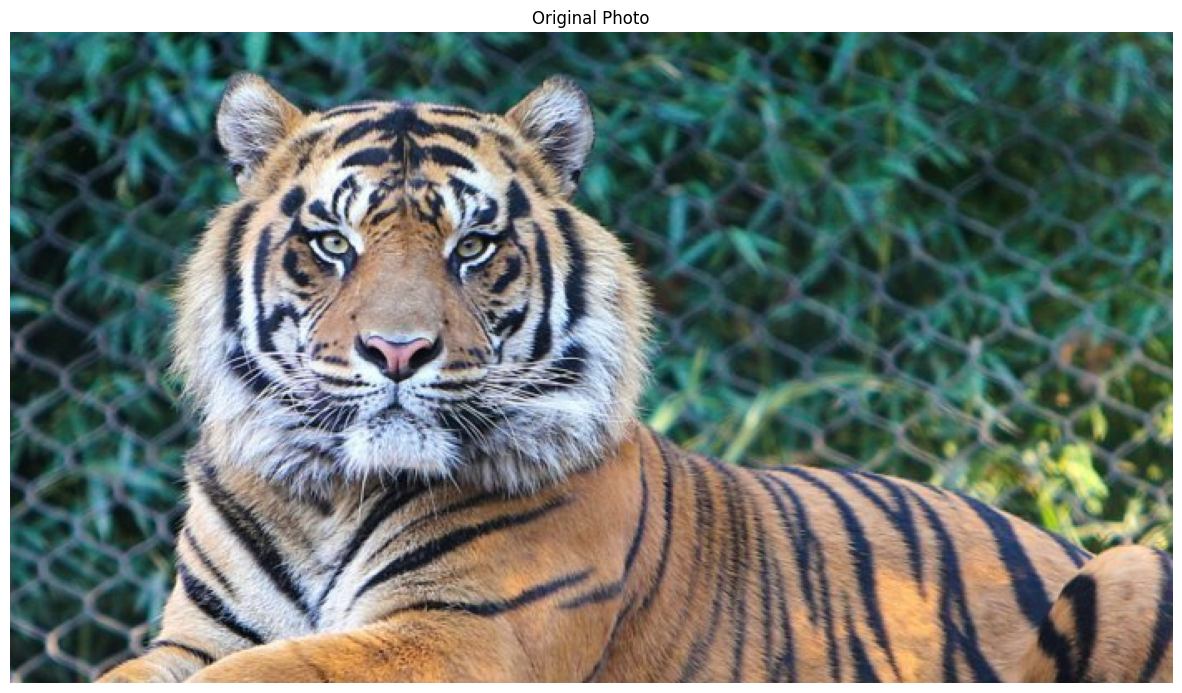

In [56]:
# Preprocess the image to make it ready for the model
load_image = preprocess_image(IMAGE_PATH)
# Plot the original image by removing the batch dimension and adding a title
plot_image(tf.squeeze(load_image),title='Original Photo')

In [57]:
# Start Performing resolution
# Start the timer to measure processing time
start = time.time()
# Use the pre-trained super-resolution model to enhance the resolution of the image
super_image = model(load_image)
# Remove the batch dimension to convert the output to a 3D tensor (height, width, channels)
super_image = tf.squeeze(super_image)
# Calculate and print the time taken to complete the resolution enhancement process
print('Time taken to complete process: %f'%(time.time() - start))

Time taken to complete process: 78.999088


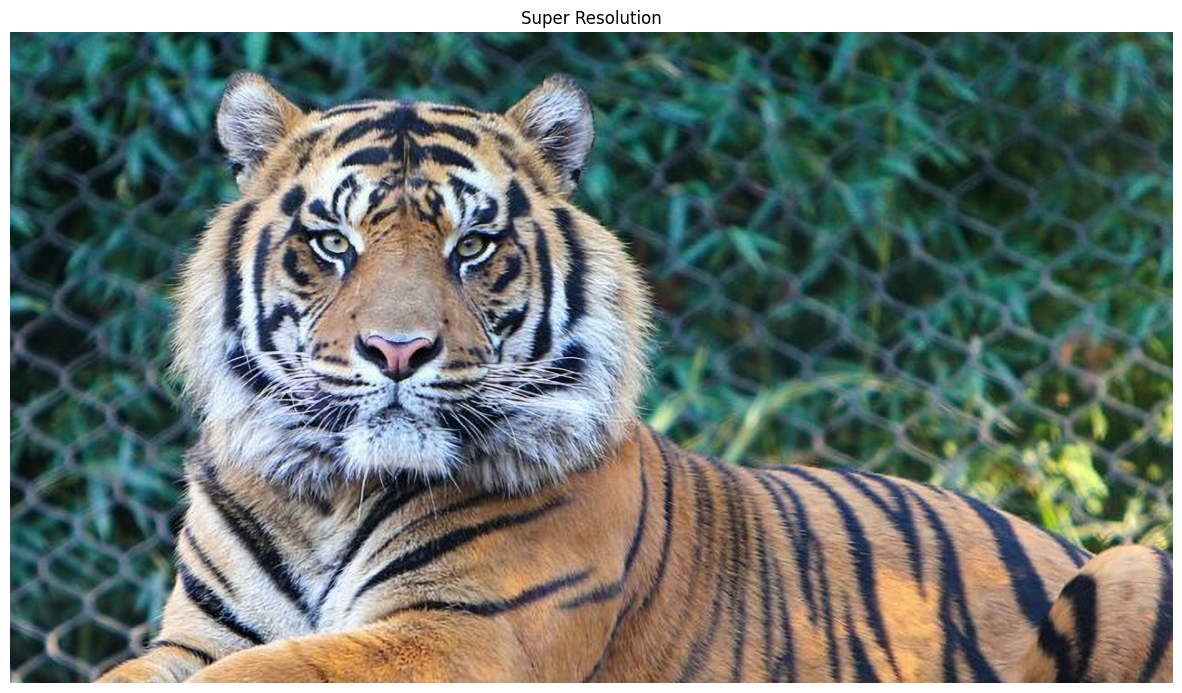

In [58]:
#plot the output image
# Plot the super-resolution image by removing any extra batch dimension and adding a title
plot_image(tf.squeeze(super_image),'Super Resolution')

In [59]:
# Define the file path for the input image
IMAGE_PATH = "tiger.jpg"

In [60]:
def downscale_image(image):
  """
      Scales down images using bicubic downsampling.
      Args:
          image: 3D or 4D tensor of preprocessed image
  """
  # Initialize an empty list to store the image size
  image_size = []
  # Check if the image is a 3D tensor (height, width, channels)
  if len(image.shape) == 3:
    # Extract the height and width of the image
    image_size = [image.shape[1], image.shape[0]]
  else:
    # Raise an error if the image dimensions are not compatible (i.e., not 3D)
    raise ValueError("Dimension mismatch. Can work only on single image.")
  # Clip the pixel values of the image to ensure they are in the valid range [0, 255]
  # Convert the tensor to uint8 type
  image = tf.squeeze(tf.cast(tf.clip_by_value(image, 0, 255), tf.uint8))
   # Resize the image to a lower resolution using bicubic downsampling
  # The new size is 1/4th of the original width and height
  lr_image = np.asarray(Image.fromarray(image.numpy()).resize([image_size[0] // 4, image_size[1] // 4],Image.BICUBIC))
  # Add a batch dimension to the downscaled image (making it 4D)
  lr_image = tf.expand_dims(lr_image, 0)
  # Cast the downscaled image to float32 (standard for deep learning models)
  lr_image = tf.cast(lr_image, tf.float32)
  # Return the downscaled image ready for processing
  return lr_image

In [61]:
# Preprocess the high-resolution image (hr_image) using the provided image path
hr_image = preprocess_image(IMAGE_PATH)

In [62]:
# Downscale the high-resolution image (hr_image) to create a low-resolution image (lr_image)
# First, the batch dimension is removed from hr_image using tf.squeeze(), then the image is downscaled.
lr_image = downscale_image(tf.squeeze(hr_image))

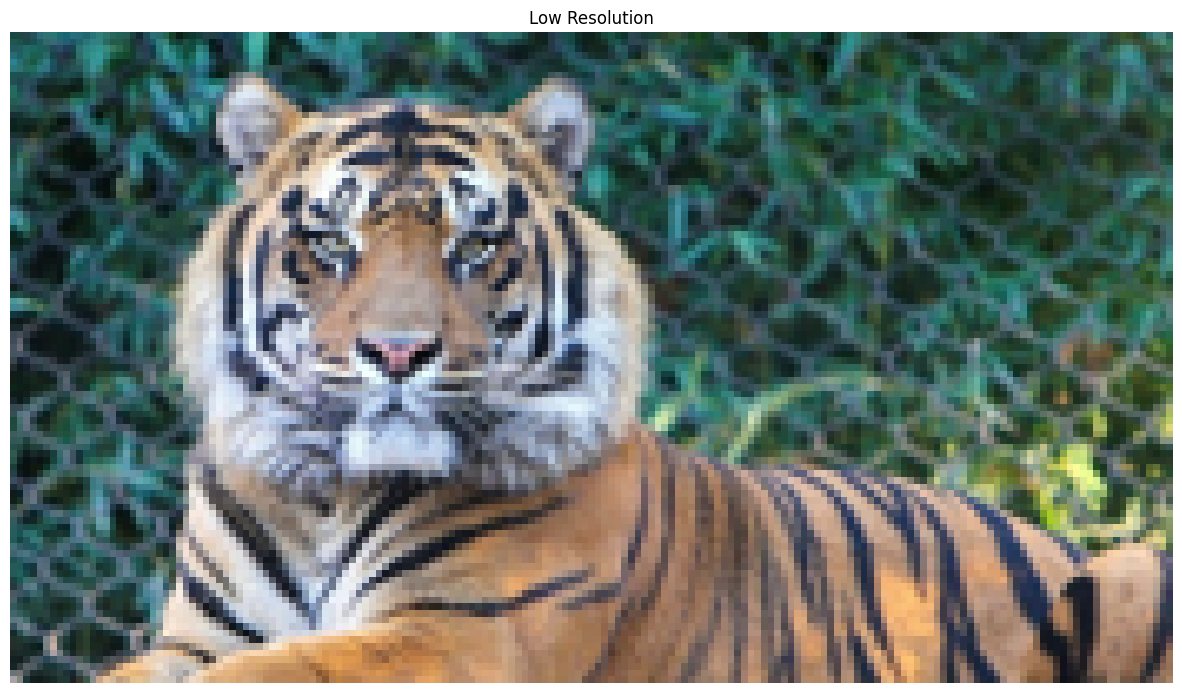

In [63]:
# Plot the low-resolution image (lr_image) by removing the batch dimension and adding a title.
plot_image(tf.squeeze(lr_image), title="Low Resolution")

In [64]:
# Start the timer to measure the time taken for the super-resolution process
start = time.time()
# Apply the pre-trained super-resolution model to the low-resolution image (lr_image)
fake_image = model(lr_image)
# Remove the batch dimension from the output image to convert it from 4D to 3D
fake_image = tf.squeeze(fake_image)
# Print the time taken for the super-resolution process
print("Time Taken: %f" % (time.time() - start))

Time Taken: 5.128356


PSNR Achieved: 25.992542


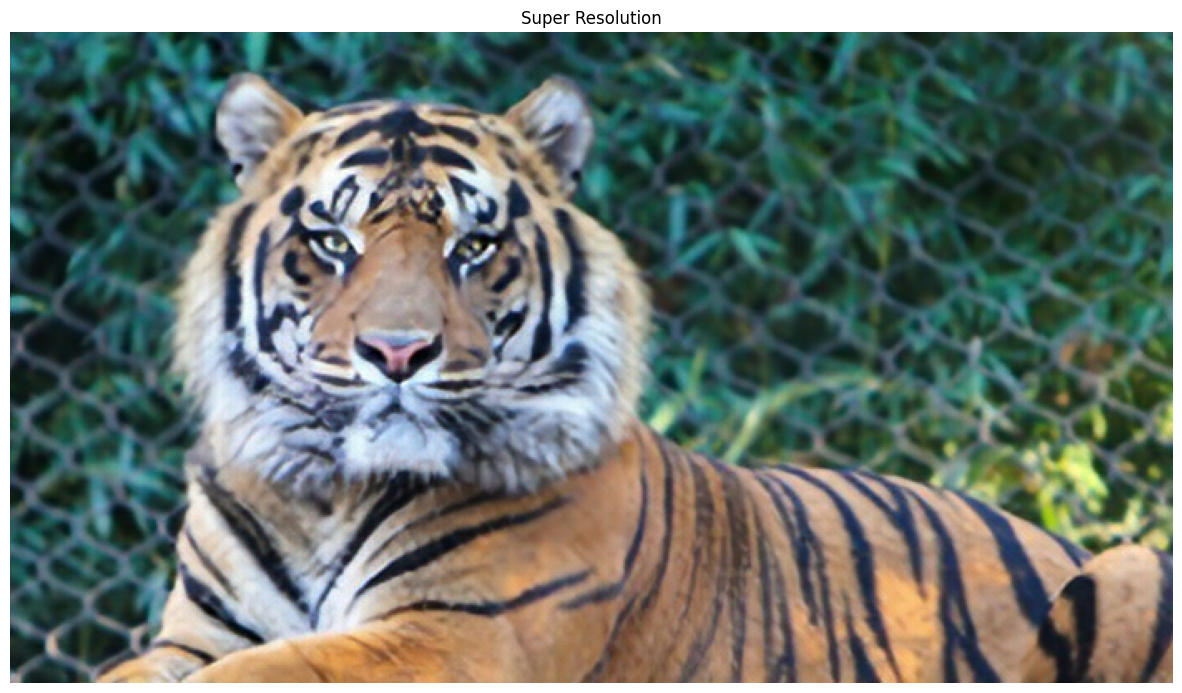

In [65]:
# Plot the super-resolution image (fake_image) by removing the batch dimension and adding a title
plot_image(tf.squeeze(fake_image), title="Super Resolution")
# Calculating PSNR wrt Original Image
# Calculate the PSNR (Peak Signal-to-Noise Ratio) between the super-resolution image (fake_image)
# and the original high-resolution image (hr_image) by clipping pixel values to the range [0, 255]
psnr = tf.image.psnr(
    # Clip pixel values of the fake image to [0, 255]
    tf.clip_by_value(fake_image, 0, 255),
    # Clip pixel values of the original high-resolution image to [0, 255]
    # Specify the maximum pixel value (255 for 8-bit images)
    tf.clip_by_value(hr_image, 0, 255), max_val=255)
# Print the calculated PSNR value
print("PSNR Achieved: %f" % psnr)

PSNR: 25.992542


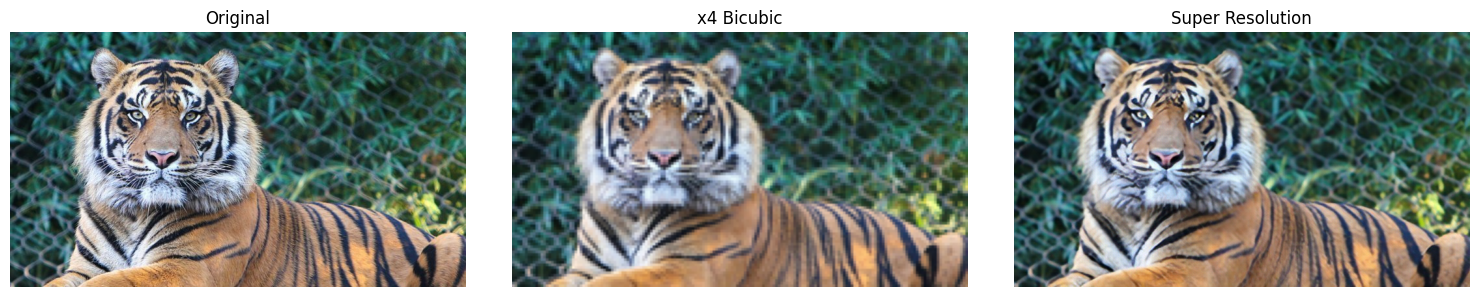

In [66]:
# Set the default size of the figure (width and height in inches) for the plots
plt.rcParams['figure.figsize'] = [15, 10]
# Create a figure and 3 subplots (1 row, 3 columns) for displaying the images
fig, axes = plt.subplots(1, 3)
# Apply tight layout to ensure that the subplots fit neatly within the figure
fig.tight_layout()
# Plot the original high-resolution image in the first subplot (left)
plt.subplot(131)
plot_image(tf.squeeze(hr_image), title="Original")
# Plot the low-resolution image (bicubic downsampled) in the second subplot (center)
plt.subplot(132)
# Ensure the layout is tight again after adding the second plot
fig.tight_layout()
plot_image(tf.squeeze(lr_image), "x4 Bicubic")
# Plot the super-resolution image (generated by the model) in the third subplot (right)
plt.subplot(133)
# Ensure the layout is tight again after adding the third plot
fig.tight_layout()
plot_image(tf.squeeze(fake_image), "Super Resolution")
# Save the figure with all three images as a single image file (ESRGAN_DIV2K.jpg)
# 'bbox_inches="tight"' ensures that the saved image has minimal padding around it
plt.savefig("ESRGAN_DIV2K.jpg", bbox_inches="tight")
# Print the PSNR value of the generated super-resolution image
print("PSNR: %f" % psnr)

In [49]:
print('--------------------------- END -----------------------')

--------------------------- END -----------------------
